# InfVis project work
---
This Python Script downloads an up-to-date dataset for **Covid-19**, gives first insights on the data and exports the data to the data folder.

The Data is from the **R**obert **K**och **I**nstitut downloaded over [ArcGis Hub](https://hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6?page=15976).

*Script was created on Python: 3.7.6 64-bit Kernel*

## Importing and installing of required packages

In [29]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from datetime import datetime

import io               # file operations
import json

import ssl              # secure client-server connection
import requests         # html-requests

In [2]:
# Uncomment next 2 lines to install jsonmerge
#import sys
#!{sys.executable} -m pip install jsonmerge
from jsonmerge import Merger

## Pulling the data from the internet

### Defining URL´s
URL´s are created from stringconcat.

In [3]:
sourceURL = 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_COVID19/FeatureServer/0/query?'
objectIdsQuery = 'where=1%3D1&returnIdsOnly=true&f=json'
dataSetQuery = 'where=ObjectId+BETWEEN+0+AND+0' # just as an example gets created later dynamically
dataQuery = '&outSR=4326&outFields=IdBundesland,Bundesland,Landkreis,Altersgruppe,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn&f=json'

In [4]:
jsonMergeSchema = {"properties":{"features":{"mergeStrategy":"append"}}}
dataMerger = Merger(jsonMergeSchema)

### First request
Check local data and Identifies downloadable data.

In [5]:
# TODO check relevance
try:
    fobjectIds = open("../data/fobjectIds.json", "r+")
except FileNotFoundError: 
    fobjectIds = open("../data/fobjectIds.json", "w+")
    print('New File created')
    latestObjectId_old = 0
else:
    print('File found')
    objectIds_old = json.load(fobjectIds)
    fobjectIds.close()
    latestObjectId_old = objectIds_old['objectIds'][len(objectIds_old['objectIds']) - 1]
    print(f'Latest ObjectId: {latestObjectId_old}')

File found
Latest ObjectId: 21321011


In [6]:
objectIdsRequest = requests.get(sourceURL + objectIdsQuery)
objectIdsRequest.status_code

200

In [7]:
objectIds = json.loads(objectIdsRequest.text)

numOfObjectIds = len(objectIds['objectIds'])

objectIdStart = objectIds['objectIds'][0]
objectIdEnd = objectIds['objectIds'][numOfObjectIds - 1]
print(f'Range of ObjectIds: [{objectIdStart}, {objectIdEnd}]')

Range of ObjectIds: [21159422, 21321011]


In [8]:
with open('../data/fobjectIds.json', 'w') as f:
    json.dump(objectIds, f)
    f.close()

### Secound request
Determines eventual limit of data transfered by the server

In [9]:
dataRequest = requests.get(sourceURL + 'where=1%3D1' + dataQuery)
dataRequest.status_code

200

In [10]:
data = json.loads(dataRequest.text)
maxApiRequest = len(data['features'])

neededRequests = math.ceil(numOfObjectIds / maxApiRequest)

print(f'The download will require {neededRequests - 1} more requests due to the server limit of {maxApiRequest} features/request.')

The download will require 32 more requests due to the server limit of 5000 features/request.


Create all requests needed to get the data for every single ObjectId.  
**Ensure the cell above is run before this one is!**  
Otherwise it **WILL** cause data to be duplicated

In [11]:
i = 0
rangeLowerEnd = data['features'][maxApiRequest - 1]['attributes']['ObjectId'] + 1
rangeUpperEnd = rangeLowerEnd + maxApiRequest

while (i < neededRequests - 1): # neededRequests - 1 because of initial download
    dataSetQuery = f'where=ObjectId+BETWEEN+{rangeLowerEnd}+AND+{rangeUpperEnd}'
    temp_sourceURL = sourceURL + dataSetQuery + dataQuery
    #print(i, temp_sourceURL)
    print(i, f'Pulling ObjectIds: [{rangeLowerEnd}, {rangeUpperEnd}]')

    temp_dataRequest = requests.get(temp_sourceURL)
    if (temp_dataRequest.status_code > 200): # stop when a request isn´t working
        print(temp_dataRequest.status_code)
        break

    temp_data = json.loads(temp_dataRequest.text)

    data = dataMerger.merge(data, temp_data)

    temp_dataLength = len(data['features'])
    t_le = data['features'][0]['attributes']['ObjectId']
    t_ue = data['features'][temp_dataLength - 1]['attributes']['ObjectId']
    print(f'Total collected features: {temp_dataLength}', f'From ObjectIds: [{t_le}, {t_ue}]')

    rangeLowerEnd = rangeUpperEnd + 1
    rangeUpperEnd += maxApiRequest + 1
    if (rangeUpperEnd > objectIdEnd):
        rangeUpperEnd = objectIdEnd
    i += 1

print('Done')

0 Pulling ObjectIds: [21164422, 21169422]
Total collected features: 10000 From ObjectIds: [21159422, 21169421]
1 Pulling ObjectIds: [21169423, 21174423]
Total collected features: 15000 From ObjectIds: [21159422, 21174422]
2 Pulling ObjectIds: [21174424, 21179424]
Total collected features: 20000 From ObjectIds: [21159422, 21179423]
3 Pulling ObjectIds: [21179425, 21184425]
Total collected features: 25000 From ObjectIds: [21159422, 21184424]
4 Pulling ObjectIds: [21184426, 21189426]
Total collected features: 30000 From ObjectIds: [21159422, 21189425]
5 Pulling ObjectIds: [21189427, 21194427]
Total collected features: 35000 From ObjectIds: [21159422, 21194426]
6 Pulling ObjectIds: [21194428, 21199428]
Total collected features: 40000 From ObjectIds: [21159422, 21199427]
7 Pulling ObjectIds: [21199429, 21204429]
Total collected features: 45000 From ObjectIds: [21159422, 21204428]
8 Pulling ObjectIds: [21204430, 21209430]
Total collected features: 50000 From ObjectIds: [21159422, 21209429]
9

In [12]:
for item in data['fields']:
    print(item['name'])

IdBundesland
Bundesland
Landkreis
Altersgruppe
AnzahlFall
AnzahlTodesfall
ObjectId
Meldedatum
IdLandkreis
Datenstand
NeuerFall
NeuerTodesfall
Refdatum
NeuGenesen
AnzahlGenesen
IstErkrankungsbeginn


In [13]:
print('Einträge: ', len(data['features']))
print('Aufbau: ', data['features'][0])

Einträge:  161559
Aufbau:  {'attributes': {'IdBundesland': 1, 'Bundesland': 'Schleswig-Holstein', 'Landkreis': 'SK Flensburg', 'Altersgruppe': 'A15-A34', 'AnzahlFall': 1, 'AnzahlTodesfall': 0, 'ObjectId': 21159422, 'Meldedatum': 1584144000000, 'IdLandkreis': '01001', 'Datenstand': '16.07.2020, 00:00 Uhr', 'NeuerFall': 0, 'NeuerTodesfall': -9, 'Refdatum': 1584316800000, 'NeuGenesen': 0, 'AnzahlGenesen': 1, 'IstErkrankungsbeginn': 1}}


In [14]:
totalCases = 0
for entry in data['features']:
    totalCases += entry['attributes']['AnzahlFall']
totalCases

200200

Testing commulated data for comparison with numbers from the internet

In [15]:
shDeaths = 0
shRecovered = 0
shEntries = 0
for entry in data['features']:
    if entry['attributes']['Bundesland'] == 'Schleswig-Holstein':
        shDeaths += entry['attributes']['AnzahlTodesfall']
        shRecovered += entry['attributes']['AnzahlGenesen']
        shEntries += 1
print('Deaths:', shDeaths, 'Recovered:', shRecovered, 'Entries:', shEntries)

Deaths: 154 Recovered: 3034 Entries: 2917


In [16]:
# reformatting the dates
for entry in data['features']:
 #   entry['attributes']['Meldedatum'] = datetime.fromtimestamp(entry['attributes']['Meldedatum'] / 1000).strftime("%x")
#    entry['attributes']['Refdatum'] = datetime.fromtimestamp(entry['attributes']['Refdatum'] / 1000).strftime("%x")
    entry['attributes']['Meldedatum'] = int(entry['attributes']['Meldedatum'] / 1000)
    entry['attributes']['Refdatum'] = int(entry['attributes']['Refdatum'] / 1000)

In [17]:
with open('../data/rki_data.json', 'w') as f:
    json.dump(data, f)
    f.close()

## Creating Pandas DataFrame

In [18]:
def display_n(df,n): 
    with pd.option_context('display.max_rows',n*2):
        display(df)

In [19]:
dfx = pd.DataFrame.from_dict(data['features'])
display_n(dfx, 2)

,attributes
0,"{'IdBundesland': 1, 'Bundesland': 'Schleswig-H..."
1,"{'IdBundesland': 1, 'Bundesland': 'Schleswig-H..."
...,...
161557,"{'IdBundesland': 16, 'Bundesland': 'Thüringen'..."
161558,"{'IdBundesland': 16, 'Bundesland': 'Thüringen'..."


In [20]:
# turning the collumn attributes in seperated collumns
for rowid in data['fields']:
    dfx[rowid['name']] = dfx.apply(lambda row: row.loc['attributes'][rowid['name']], axis=1)
dfx = dfx.drop(['attributes'], axis=1)

In [21]:
display_n(dfx, 2)

,IdBundesland,Bundesland,Landkreis,Altersgruppe,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn
0,1,Schleswig-Holstein,SK Flensburg,A15-A34,1,0,21159422,1584144000,01001,"16.07.2020, 00:00 Uhr",0,-9,1584316800,0,1,1
1,1,Schleswig-Holstein,SK Flensburg,A15-A34,1,0,21159423,1584576000,01001,"16.07.2020, 00:00 Uhr",0,-9,1584057600,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161557,16,Thüringen,LK Altenburger Land,A80+,2,0,21321010,1590624000,16077,"16.07.2020, 00:00 Uhr",0,-9,1590624000,0,2,0
161558,16,Thüringen,LK Altenburger Land,A80+,1,0,21321011,1591660800,16077,"16.07.2020, 00:00 Uhr",0,-9,1591660800,0,1,0


In [27]:
data = dfx.drop(columns=['Meldedatum', 'Datenstand', 'ObjectId'])

In [28]:
display_n(data, 2)

,IdBundesland,Bundesland,Landkreis,Altersgruppe,AnzahlFall,AnzahlTodesfall,IdLandkreis,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn
0,1,Schleswig-Holstein,SK Flensburg,A15-A34,1,0,01001,0,-9,1584316800,0,1,1
1,1,Schleswig-Holstein,SK Flensburg,A15-A34,1,0,01001,0,-9,1584057600,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161557,16,Thüringen,LK Altenburger Land,A80+,2,0,16077,0,-9,1590624000,0,2,0
161558,16,Thüringen,LK Altenburger Land,A80+,1,0,16077,0,-9,1591660800,0,1,0


In [22]:
frame_byBundesland = dfx.groupby(['Bundesland'])['AnzahlFall', 'AnzahlTodesfall', 'AnzahlGenesen'].sum().reset_index()
frame_byBundesland = frame_byBundesland.set_index('Bundesland')

In [23]:
frame_byBundesland

,AnzahlFall,AnzahlTodesfall,AnzahlGenesen
Bundesland,,,
Baden-Württemberg,36219,1838,33840
Bayern,49523,2612,45967
Berlin,8697,221,8156
Brandenburg,3464,167,3259
Bremen,1697,55,1621
Hamburg,5230,261,4916
Hessen,11278,514,10389
Mecklenburg-Vorpommern,805,20,784
Niedersachsen,13885,643,12995


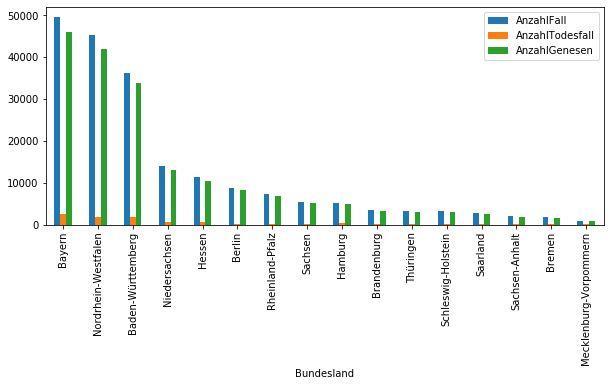

In [24]:
frame_byBundesland = frame_byBundesland.sort_values(by='AnzahlFall', ascending=False)
ax = frame_byBundesland.plot.bar(figsize=(10,4))

---

In [222]:
dfx_grouped = dfx.drop(columns=['IdBundesland', 'ObjectId', 'NeuerFall', 'NeuerTodesfall', 'IstErkrankungsbeginn', 'NeuGenesen', 'Meldedatum', 'Datenstand', 'IdLandkreis']).groupby(['Bundesland', 'Landkreis', 'Altersgruppe', 'Refdatum']).agg({'AnzahlFall': sum, 'AnzahlTodesfall': sum, 'AnzahlGenesen': sum})

In [223]:
dfx_grouped.head(40)

AnzahlFall  \
Bundesland        Landkreis          Altersgruppe Refdatum                 
Baden-Württemberg LK Alb-Donau-Kreis A00-A04      1583107200           1   
                                                  1584403200           1   
                                                  1585094400           1   
                                                  1586044800           1   
                                                  1589760000           1   
                                     A05-A14      1583798400           1   
                                                  1584057600           1   
                                                  1584403200           1   
                                                  1584489600           1   
                                                  1584662400           1   
                                                  1584835200           1   
                                                  1585008000           2   
                                                  1585267200           1   
                                                  1585612800           1   
                                                  1585699200           1   
                                                  1586304000           1   
                                                  1587686400           1   
                                                  1589155200           1   
                                                  1589932800           1   
                                                  1590192000           1   
                                     A15-A34      1583712000           1   
                                                  1583884800           1   
                                                  1583971200           2   
                                                  1584057600           1   
                                                  1584144000           4   
                                                  1584230400           6   
                                                  1584316800           9   
                                                  1584403200           2   
                                                  1584489600           5   
                                                  1584576000           4   
                                                  1584662400           4   
                                                  1584748800           4   
                                                  1584835200           5   
                                                  1584921600           5   
                                                  1585008000           8   
                                                  1585094400           5   
                                                  1585180800           6   
                                                  1585267200           4   
                                                  1585353600           3   
                                                  1585440000           1   

                                                              AnzahlTodesfall  \
Bundesland        Landkreis          Altersgruppe Refdatum                      
Baden-Württemberg LK Alb-Donau-Kreis A00-A04      1583107200                0   
                                                  1584403200                0   
                                                  1585094400                0   
                                                  1586044800                0   
                                                  1589760000                0   
                                     A05-A14      1583798400                0   
                                                  1584057600                0   
                                                  1584403200                0   
                                                  158448960

In [116]:
dfx_grouped['AnzahlFall'].sum()

Bundesland         Landkreis           Altersgruppe  Refdatum  
Baden-Württemberg  LK Alb-Donau-Kreis  A00-A04       1583107200    1
                                                     1584403200    1
                                                     1585094400    1
                                                     1586044800    1
                                                     1589760000    1
                                                                  ..
Thüringen          SK Weimar           A80+          1584662400    1
                                                     1584921600    1
                                                     1585267200    1
                                                     1585440000    1
                                                     1587340800    1
Name: AnzahlFall, Length: 73145, dtype: int64

In [92]:
a.drop('')